In [1]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import os, glob
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
from skimage.measure import block_reduce
from numpy.lib.stride_tricks import as_strided
plt.style.use([hep.style.ROOT, hep.style.firamath])
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LogNorm, ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
# Define the CMS color scheme
cms_colors = [
    (0.00, '#FFFFFF'),  # White
    (0.33, '#005EB8'),  # Blue
    (0.66, '#FFDD00'),  # Yellow
    (1.00, '#FF0000')   # red
]

# Create the CMS colormap
cms_cmap = LinearSegmentedColormap.from_list('CMS', cms_colors)
from numpy.lib.stride_tricks import as_strided




Matplotlib created a temporary config/cache directory at /tmp/matplotlib-exmx0cxz because the default path (/uscms/home/bbbam/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [61]:
# out_dir='data/plot_H_AA_4Tau_M_10_signal_kinematics'
out_dir='../analysis_run3/AN_Note_Plot'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)
save = True

In [3]:
def upsample_array(x, b0, b1):
    r, c = x.shape                                    # number of rows/columns
    rs, cs = x.strides                                # row/column strides
    x = as_strided(x, (r, b0, c, b1), (rs, 0, cs, 0)) # view as a larger 4D array
    return x.reshape(r*b0, c*b1)/(b0*b1) # create new 2D array with same total occupancy
    


def crop_jet(imgECAL, iphi, ieta, jet_shape=125):

    # NOTE: jet_shape here should correspond to the one used in RHAnalyzer
    off = jet_shape//2
    iphi = int(iphi*5 + 2) # 5 EB xtals per HB tower
    ieta = int(ieta*5 + 2) # 5 EB xtals per HB tower

    # Wrap-around on left side
    if iphi < off:
        diff = off-iphi
        img_crop = np.concatenate((imgECAL[:,ieta-off:ieta+off+1,-diff:],
                                   imgECAL[:,ieta-off:ieta+off+1,:iphi+off+1]), axis=-1)
    # Wrap-around on right side
    elif 360-iphi < off:
        diff = off - (360-iphi)
        img_crop = np.concatenate((imgECAL[:,ieta-off:ieta+off+1,iphi-off:],
                                   imgECAL[:,ieta-off:ieta+off+1,:diff+1]), axis=-1)
    # Nominal case
    else:
        img_crop = imgECAL[:,ieta-off:ieta+off+1,iphi-off:iphi+off+1]

    return img_crop

### Layesrs in images

In [4]:
layers =['TracksAtECAL_pt', 'TracAtECAL_dZSig', 'TracAtECAL_d0Sig', 'ECAL_energy', \
         'HBHE_energy', 'PixAtEcal_1','PixAtEcal_2', 'PixAtEcal_3', 'PixAtEcal_4', 'TibAtEcal_1',\
         'TibAtEcal_2', 'TibAtEcal_3','TibAtEcal_4', 'TobAtEcal_1','TobAtEcal_2', 'TobAtEcal_3', \
         'TobAtEcal_4', 'TobAtEcal_5', 'TobAtEcal_6' , 'TidAtEcal_1',\
                                  'TecAtEcal_1', 'TecAtEcal_2', 'TecAtEcal_3']
print("Number of layers", len(layers))


Number of layers 23


### Plotting function

In [6]:
def plotJet_single_layer(img, eve, run):
    img[np.abs(img) < 1.e-3] = 0 # to rmove noise
    mins = [0.00001]*len(img)
    maxs =[]
    for j in range(len(img)):
         maxs.append(img[j].max())
    # out_dir='plot_for_prelim'
    # if not os.path.isdir(out_dir):
    #     os.makedirs(out_dir)
    for k in range(len(img)):
        fig, ax = plt.subplots(dpi=300)
        color = ['Oranges','Blues','Greys','Greens', 'Blues']
        if k<5:
            color_selected = color[k]
        else:
            color_selected = color[2]
            
        if maxs[k]  > 0 : plt.imshow(img[k], cmap=f'{color_selected}', norm=LogNorm(vmin=mins[k], vmax=maxs[k]),  alpha=0.9)
        # plt.title(f"{layers[k]}")
        hep.cms.label(llabel=f"Simulation  " +layers[k] , rlabel="13.6 TeV", loc=0, ax=ax)
        plt.xlabel(r"$i\varphi$") #28, 30
        plt.ylabel(r"$i\eta$") #28, 30

        # plt.savefig(f'{out_dir}/single_layer_image_event_{eve}_{layers[k]}.pdf',facecolor='w',dpi=300)
        plt.show()
    return img 


def plotJet(img, eve, dr):
    mins = [0.001]*len(img)
    maxs =[]
    for i in range(len(img)):
        maxs.append(img[i].max())
    fig, ax = plt.subplots(dpi=300)
    if maxs[0]  > 0 : plt.imshow(img[0], cmap='Oranges', norm=LogNorm(vmin=mins[0], vmax=maxs[0]),  alpha=0.9)
    if maxs[1]  > 0 : plt.imshow(img[1], cmap='Blues',   norm=LogNorm(vmin=mins[1], vmax=maxs[1]),  alpha=0.9)
    if maxs[2]  > 0 : plt.imshow(img[2], cmap='Greys',   norm=LogNorm(vmin=mins[2], vmax=maxs[2]),  alpha=0.9)
    if maxs[3]  > 0 : plt.imshow(img[3], cmap='Greens',  norm=LogNorm(vmin=mins[3], vmax=maxs[3]),  alpha=0.9)       
    if maxs[4]  > 0 : plt.imshow(img[4], cmap='Blues',   norm=LogNorm(vmin=mins[4], vmax=maxs[4]),  alpha=0.4)   
    if maxs[5]  > 0 : plt.imshow(img[5], cmap='Purples', norm=LogNorm(vmin=mins[5], vmax=maxs[5]),  alpha=0.9)   
    if maxs[10] > 0 : plt.imshow(img[10], cmap= 'pink',  norm=LogNorm(vmin=mins[10],vmax=maxs[10]), alpha=0.9)
    hep.cms.label(llabel=r"Simulation     $\Delta R_{\tau\tau}$"+f"={dr:.3f}", rlabel=f"13.6 TeV", loc=0, ax=ax)
    plt.xlabel(r"$i\varphi$") #28, 30
    plt.ylabel(r"$i\eta$") #28, 30
    #LEGEND
    colors = {0:'orange',1:'blue',2:'grey',3:'green',4:'lightblue',5:'purple',6:'pink'}
    labels = {0:'Track pT',1:'dz_sig',2:'d0_sig',3:'ECAL',4:'HCAL',5:'BPix L1',6:'BStrip L1'}
    patches =[mpatches.Patch(color=colors[i],label=labels[i]) for i in colors]
    plt.legend(handles=patches, bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.,fontsize=10 )
    plt.tight_layout()
    dr = np.round(dr,3)
    dr_str = str(dr).replace('.', 'p')
    # plt.savefig(f"{out_dir}/combined_image_event_{eve}_dr_{dr_str}.pdf",facecolor='w',dpi=300,)
    plt.show()

### Plot cropped images function

In [8]:

def make_img_eve_cropped(i):
    ECAL_energy = np.array(branches["ECAL_energy"][i]).reshape(280,360)
    HBHE_energy_ = np.array(branches["HBHE_energy"][i]).reshape(56,72)
    HBHE_energy = upsample_array(HBHE_energy_, 5, 5) # (280, 360)
    TracksAtECAL_pt = np.array(branches["ECAL_tracksPt_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_dZSig = np.array(branches["ECAL_tracksDzSig_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_d0Sig = np.array(branches["ECAL_tracksD0Sig_atECALfixIP"][i]).reshape(280,360)
    PixAtEcal_1        = np.array(branches["BPIX_layer1_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_2        = np.array(branches["BPIX_layer2_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_3        = np.array(branches["BPIX_layer3_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_4        = np.array(branches["BPIX_layer4_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_1        = np.array(branches["TIB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_2        = np.array(branches["TIB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_3        = np.array(branches["TIB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_4        = np.array(branches["TIB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_1        = np.array(branches["TOB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_2        = np.array(branches["TOB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_3        = np.array(branches["TOB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_4        = np.array(branches["TOB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_5        = np.array(branches["TOB_layer5_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_6        = np.array(branches["TOB_layer6_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_1        = np.array(branches["TEC_layer1_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_2        = np.array(branches["TEC_layer2_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_3        = np.array(branches["TEC_layer3_ECAL_atPV"][i]).reshape(280,360)
    TidAtEcal_1        = np.array(branches["TID_layer1_ECAL_atPV"][i]).reshape(280,360)
    X_CMS             = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy, PixAtEcal_1,\
    PixAtEcal_2, PixAtEcal_3, PixAtEcal_4, TibAtEcal_1, TibAtEcal_2, TibAtEcal_3, TibAtEcal_4, TobAtEcal_1,\
                                  TobAtEcal_2, TobAtEcal_3, TobAtEcal_4, TobAtEcal_5, TobAtEcal_6, TidAtEcal_1,\
                                  TecAtEcal_1, TecAtEcal_2, TecAtEcal_3], axis=0) # (23, 280, 360)
    # ys = ak.Array(branches["jetIsSignal"])[i]
    ys = ak.Array(branches["jetIsDiTau"])[i]
    iphis  = ak.Array(branches["jetSeed_iphi"])[i]
    ietas  = ak.Array(branches["jetSeed_ieta"])[i]
    dR = ak.Array(branches["TaudR"])[i]
    print("Event Number:", i)
    for j in range(len(ys)):
        img_cropped = crop_jet(X_CMS, iphis[j], ietas[j], jet_shape=125)
        plotJet(img_cropped, i, dR[j])
        break
        
def make_img_all_layers_cropped(i, run):
    ECAL_energy = np.array(branches["ECAL_energy"][i]).reshape(280,360)
    HBHE_energy_ = np.array(branches["HBHE_energy"][i]).reshape(56,72)
    HBHE_energy = upsample_array(HBHE_energy_, 5, 5) # (280, 360)
    TracksAtECAL_pt = np.array(branches["ECAL_tracksPt_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_dZSig = np.array(branches["ECAL_tracksDzSig_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_d0Sig = np.array(branches["ECAL_tracksD0Sig_atECALfixIP"][i]).reshape(280,360)
    PixAtEcal_1        = np.array(branches["BPIX_layer1_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_2        = np.array(branches["BPIX_layer2_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_3        = np.array(branches["BPIX_layer3_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_4        = np.array(branches["BPIX_layer4_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_1        = np.array(branches["TIB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_2        = np.array(branches["TIB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_3        = np.array(branches["TIB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_4        = np.array(branches["TIB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_1        = np.array(branches["TOB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_2        = np.array(branches["TOB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_3        = np.array(branches["TOB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_4        = np.array(branches["TOB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_5        = np.array(branches["TOB_layer5_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_6        = np.array(branches["TOB_layer6_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_1        = np.array(branches["TEC_layer1_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_2        = np.array(branches["TEC_layer2_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_3        = np.array(branches["TEC_layer3_ECAL_atPV"][i]).reshape(280,360)
    TidAtEcal_1        = np.array(branches["TID_layer1_ECAL_atPV"][i]).reshape(280,360)
    X_CMS             = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy, PixAtEcal_1,\
    PixAtEcal_2, PixAtEcal_3, PixAtEcal_4, TibAtEcal_1, TibAtEcal_2, TibAtEcal_3, TibAtEcal_4, TobAtEcal_1,\
                                  TobAtEcal_2, TobAtEcal_3, TobAtEcal_4, TobAtEcal_5, TobAtEcal_6, TidAtEcal_1,\
                                  TecAtEcal_1, TecAtEcal_2, TecAtEcal_3], axis=0) # (23, 280, 360)
    # ys = ak.Array(branches["jetIsSignal"])[i]
    ys = ak.Array(branches["jetIsDiTau"])[i]
    iphis  = ak.Array(branches["jetSeed_iphi"])[i]
    ietas  = ak.Array(branches["jetSeed_ieta"])[i]
    
    for j in range(len(ys)):
        img_cropped = crop_jet(X_CMS, iphis[j], ietas[j], jet_shape=125)
        plotJet_single_layer(img_cropped, i, run)
        break
  

### Plot full image function

In [9]:

def make_img_eve_full(i, run):
    ECAL_energy = np.array(branches["ECAL_energy"][i]).reshape(280,360)
    HBHE_energy_ = np.array(branches["HBHE_energy"][i]).reshape(56,72)
    HBHE_energy = upsample_array(HBHE_energy_, 5, 5) # (280, 360)
    TracksAtECAL_pt = np.array(branches["ECAL_tracksPt_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_dZSig = np.array(branches["ECAL_tracksDzSig_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_d0Sig = np.array(branches["ECAL_tracksD0Sig_atECALfixIP"][i]).reshape(280,360)
    PixAtEcal_1        = np.array(branches["BPIX_layer1_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_2        = np.array(branches["BPIX_layer2_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_3        = np.array(branches["BPIX_layer3_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_4        = np.array(branches["BPIX_layer4_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_1        = np.array(branches["TIB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_2        = np.array(branches["TIB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_3        = np.array(branches["TIB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_4        = np.array(branches["TIB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_1        = np.array(branches["TOB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_2        = np.array(branches["TOB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_3        = np.array(branches["TOB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_4        = np.array(branches["TOB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_5        = np.array(branches["TOB_layer5_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_6        = np.array(branches["TOB_layer6_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_1        = np.array(branches["TEC_layer1_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_2        = np.array(branches["TEC_layer2_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_3        = np.array(branches["TEC_layer3_ECAL_atPV"][i]).reshape(280,360)
    TidAtEcal_1        = np.array(branches["TID_layer1_ECAL_atPV"][i]).reshape(280,360)
    X_CMS             = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy, PixAtEcal_1,\
    PixAtEcal_2, PixAtEcal_3, PixAtEcal_4, TibAtEcal_1, TibAtEcal_2, TibAtEcal_3, TibAtEcal_4, TobAtEcal_1,\
                                  TobAtEcal_2, TobAtEcal_3, TobAtEcal_4, TobAtEcal_5, TobAtEcal_6, TidAtEcal_1,\
                                  TecAtEcal_1, TecAtEcal_2, TecAtEcal_3], axis=0) # (23, 280, 360)
    plotJet(X_CMS, i, run)
        
def make_img_all_layers_full(i, run):
    ECAL_energy = np.array(branches["ECAL_energy"][i]).reshape(280,360)
    HBHE_energy_ = np.array(branches["HBHE_energy"][i]).reshape(56,72)
    HBHE_energy = upsample_array(HBHE_energy_, 5, 5) # (280, 360)
    TracksAtECAL_pt = np.array(branches["ECAL_tracksPt_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_dZSig = np.array(branches["ECAL_tracksDzSig_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_d0Sig = np.array(branches["ECAL_tracksD0Sig_atECALfixIP"][i]).reshape(280,360)
    PixAtEcal_1        = np.array(branches["BPIX_layer1_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_2        = np.array(branches["BPIX_layer2_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_3        = np.array(branches["BPIX_layer3_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_4        = np.array(branches["BPIX_layer4_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_1        = np.array(branches["TIB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_2        = np.array(branches["TIB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_3        = np.array(branches["TIB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_4        = np.array(branches["TIB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_1        = np.array(branches["TOB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_2        = np.array(branches["TOB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_3        = np.array(branches["TOB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_4        = np.array(branches["TOB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_5        = np.array(branches["TOB_layer5_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_6        = np.array(branches["TOB_layer6_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_1        = np.array(branches["TEC_layer1_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_2        = np.array(branches["TEC_layer2_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_3        = np.array(branches["TEC_layer3_ECAL_atPV"][i]).reshape(280,360)
    TidAtEcal_1        = np.array(branches["TID_layer1_ECAL_atPV"][i]).reshape(280,360)
    X_CMS             = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy, PixAtEcal_1,\
    PixAtEcal_2, PixAtEcal_3, PixAtEcal_4, TibAtEcal_1, TibAtEcal_2, TibAtEcal_3, TibAtEcal_4, TobAtEcal_1,\
                                  TobAtEcal_2, TobAtEcal_3, TobAtEcal_4, TobAtEcal_5, TobAtEcal_6, TidAtEcal_1,\
                                  TecAtEcal_1, TecAtEcal_2, TecAtEcal_3], axis=0) # (23, 280, 360)
    iphis  = ak.Array(branches["jetSeed_iphi"])[i]
    ietas  = ak.Array(branches["jetSeed_ieta"])[i]
    am     = ak.Array(branches["a_m"])[i]
    mass = am[0]
    
    # print(iphis)
    # print(ietas)
    if  (len(iphis) >1)&(mass>0) & (mass<18):
        # print(i,mass)
        plotJet_full_single_layer(X_CMS, i, run, iphis, ietas, mass)   
  

In [63]:
def plotJet_full_circle(img, eve, phi, eta):
    mins = [0.001]*len(img)
    maxs =[]
    for i in range(len(img)):
        maxs.append(img[i].max())
    fig, ax = plt.subplots(dpi=300)
    if maxs[0]  > 0 : plt.imshow(img[0], cmap='Oranges', norm=LogNorm(vmin=mins[0], vmax=maxs[0]),  alpha=0.9)
    if maxs[1]  > 0 : plt.imshow(img[1], cmap='Blues',   norm=LogNorm(vmin=mins[1], vmax=maxs[1]),  alpha=0.9)
    if maxs[2]  > 0 : plt.imshow(img[2], cmap='Greys',   norm=LogNorm(vmin=mins[2], vmax=maxs[2]),  alpha=0.9)
    if maxs[3]  > 0 : plt.imshow(img[3], cmap='Greens',  norm=LogNorm(vmin=mins[3], vmax=maxs[3]),  alpha=0.9)       
    if maxs[4]  > 0 : plt.imshow(img[4], cmap='Blues',   norm=LogNorm(vmin=mins[4], vmax=maxs[4]),  alpha=0.4)   
    if maxs[5]  > 0 : plt.imshow(img[5], cmap='Purples', norm=LogNorm(vmin=mins[5], vmax=maxs[5]),  alpha=0.9)   
    if maxs[10] > 0 : plt.imshow(img[10], cmap= 'pink',  norm=LogNorm(vmin=mins[10],vmax=maxs[10]), alpha=0.9)
    hep.cms.label(llabel=r"Simulation ", rlabel=f"13.6 TeV", loc=0, ax=ax)
    plt.xlabel(r"$i\varphi$") #28, 30
    plt.ylabel(r"$i\eta$") #28, 30
    #LEGEND
    colors = {0:'orange',1:'blue',2:'grey',3:'green',4:'lightblue',5:'purple',6:'pink'}
    labels = {0:'Track pT',1:'dz_sig',2:'d0_sig',3:'ECAL',4:'HCAL',5:'BPix L1',6:'BStrip L1'}
    patches =[mpatches.Patch(color=colors[i],label=labels[i]) for i in colors]
    plt.legend(handles=patches, bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.,fontsize=10 )
    import matplotlib.patches as patches

    # Add circle centered in the image
    circle_radius = 25
    circle1 = patches.Circle((5*phi[0], 5*eta[0]), radius=circle_radius, linewidth=1.8,
                     edgecolor='green', facecolor='none', linestyle='--')
    circle2 = patches.Circle((5*phi[1], 5*eta[1]), radius=circle_radius, linewidth=1.8,
                             edgecolor='red', facecolor='none', linestyle='--')
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    plt.tight_layout()
    # plt.savefig(f"{out_dir}/combined_image_circled_event_{eve}.pdf",facecolor='w',dpi=300,)
    plt.show()

def plotJet_full_circle_cropped(img, eve, position, phi, eta):
    mins = [0.001]*len(img)
    maxs =[]
    for i in range(len(img)):
        maxs.append(img[i].max())
    fig, ax = plt.subplots(dpi=300)
    if maxs[0]  > 0 : plt.imshow(img[0], cmap='Oranges', norm=LogNorm(vmin=mins[0], vmax=maxs[0]),  alpha=0.9)
    if maxs[1]  > 0 : plt.imshow(img[1], cmap='Blues',   norm=LogNorm(vmin=mins[1], vmax=maxs[1]),  alpha=0.9)
    if maxs[2]  > 0 : plt.imshow(img[2], cmap='Greys',   norm=LogNorm(vmin=mins[2], vmax=maxs[2]),  alpha=0.9)
    if maxs[3]  > 0 : plt.imshow(img[3], cmap='Greens',  norm=LogNorm(vmin=mins[3], vmax=maxs[3]),  alpha=0.9)       
    if maxs[4]  > 0 : plt.imshow(img[4], cmap='Blues',   norm=LogNorm(vmin=mins[4], vmax=maxs[4]),  alpha=0.4)   
    if maxs[5]  > 0 : plt.imshow(img[5], cmap='Purples', norm=LogNorm(vmin=mins[5], vmax=maxs[5]),  alpha=0.9)   
    if maxs[10] > 0 : plt.imshow(img[10], cmap= 'pink',  norm=LogNorm(vmin=mins[10],vmax=maxs[10]), alpha=0.9)
    hep.cms.label(llabel=r"Simulation", rlabel=f"13.6 TeV", loc=0, ax=ax)
    plt.xlabel(r"$i\varphi$") #28, 30
    plt.ylabel(r"$i\eta$") #28, 30
    #LEGEND
    colors = {0:'orange',1:'blue',2:'grey',3:'green',4:'lightblue',5:'purple',6:'pink'}
    labels = {0:'Track pT',1:'dz_sig',2:'d0_sig',3:'ECAL',4:'HCAL',5:'BPix L1',6:'BStrip L1'}
    patches =[mpatches.Patch(color=colors[i],label=labels[i]) for i in colors]
    plt.legend(handles=patches, bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.,fontsize=10 )
    import matplotlib.patches as patches

    # Add circle centered in the image
    circle_radius = 20
    if position==0:
        circle1 = patches.Circle((62.5, 62.5), radius=circle_radius, linewidth=1.8,
                         edgecolor='green', facecolor='none', linestyle='--')
        ax.add_patch(circle1)
    if position==1:
        circle2 = patches.Circle((62.5, 62.5), radius=circle_radius, linewidth=1.8,
                                 edgecolor='red', facecolor='none', linestyle='--')
    
        ax.add_patch(circle2)
    plt.tight_layout()
    # plt.savefig(f"{out_dir}/cropped_combined_image_circled_{position}_event_{eve}.pdf",facecolor='w',dpi=300,)
    plt.show()

def plotJet_full_single_layer(img, eve, run, phi, eta, mass):
    # img[np.abs(img) < 1.e-3] = 0 # to rmove noise
    mins = [0.00001]*len(img)
    maxs =[]
    for j in range(len(img)):
         maxs.append(img[j].max())
    # out_dir='plot_for_prelim'
    # if not os.path.isdir(out_dir):
    #     os.makedirs(out_dir)
    for k in range(len(img)):
        fig, ax = plt.subplots(figsize=(15,12), dpi=300)
        color = ['Oranges','Blues','Greys','Greens', 'Blues']
        if k<5:
            color_selected = color[k]
        else:
            color_selected = color[2]
            
        if maxs[k]  > 0 : plt.imshow(img[k], cmap=f'{color_selected}', norm=LogNorm(vmin=mins[k], vmax=maxs[k]),  alpha=0.9)
        import matplotlib.patches as patches

        # Add circle centered in the image
        circle_radius = 25
        circle1 = patches.Circle((5*phi[0], 5*eta[0]), radius=circle_radius, linewidth=1.8,
                         edgecolor='red', facecolor='none', linestyle='--')
        circle2 = patches.Circle((5*phi[1], 5*eta[1]), radius=circle_radius, linewidth=1.8,
                                 edgecolor='red', facecolor='none', linestyle='--')
        ax.add_patch(circle1)
        ax.add_patch(circle2)
       
        # plt.title(f"{layers[k]}")
        hep.cms.label(llabel=f"Simulation {layers[k]}", rlabel=f"A_true= {mass:.2f} GeV         13.6 TeV", loc=0, ax=ax)
        plt.xlabel(r"$i\varphi$") #28, 30
        plt.ylabel(r"$i\eta$") #28, 30

        # plt.savefig(f'{out_dir}/full_image_{layers[k]}_massreg_mass_{mass:.2f}.pdf',facecolor='w',dpi=300)
        plt.show()
    return img 


In [64]:
def make_img_eve_full_circle_and_cropped_circle(i):
    ECAL_energy = np.array(branches["ECAL_energy"][i]).reshape(280,360)
    HBHE_energy_ = np.array(branches["HBHE_energy"][i]).reshape(56,72)
    HBHE_energy = upsample_array(HBHE_energy_, 5, 5) # (280, 360)
    TracksAtECAL_pt = np.array(branches["ECAL_tracksPt_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_dZSig = np.array(branches["ECAL_tracksDzSig_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_d0Sig = np.array(branches["ECAL_tracksD0Sig_atECALfixIP"][i]).reshape(280,360)
    PixAtEcal_1        = np.array(branches["BPIX_layer1_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_2        = np.array(branches["BPIX_layer2_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_3        = np.array(branches["BPIX_layer3_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_4        = np.array(branches["BPIX_layer4_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_1        = np.array(branches["TIB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_2        = np.array(branches["TIB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_3        = np.array(branches["TIB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_4        = np.array(branches["TIB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_1        = np.array(branches["TOB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_2        = np.array(branches["TOB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_3        = np.array(branches["TOB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_4        = np.array(branches["TOB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_5        = np.array(branches["TOB_layer5_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_6        = np.array(branches["TOB_layer6_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_1        = np.array(branches["TEC_layer1_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_2        = np.array(branches["TEC_layer2_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_3        = np.array(branches["TEC_layer3_ECAL_atPV"][i]).reshape(280,360)
    TidAtEcal_1        = np.array(branches["TID_layer1_ECAL_atPV"][i]).reshape(280,360)
    iphis              = ak.Array(branches["jetSeed_iphi"])[i]
    ietas              = ak.Array(branches["jetSeed_ieta"])[i]
    print(iphis)
    print(ietas)
    if min(len(iphis),len(ietas))==2:
        X_CMS             = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy, PixAtEcal_1,\
        PixAtEcal_2, PixAtEcal_3, PixAtEcal_4, TibAtEcal_1, TibAtEcal_2, TibAtEcal_3, TibAtEcal_4, TobAtEcal_1,\
                                      TobAtEcal_2, TobAtEcal_3, TobAtEcal_4, TobAtEcal_5, TobAtEcal_6, TidAtEcal_1,\
                                      TecAtEcal_1, TecAtEcal_2, TecAtEcal_3], axis=0) # (23, 280, 360)
        plotJet_full_circle(X_CMS,i, iphis, ietas)
        for position in [0, 1]:
            img_cropped = crop_jet(X_CMS, iphis[position], ietas[position], jet_shape=125)
            plotJet_full_circle_cropped(img_cropped, i, position, iphis[position], ietas[position])
        

## Run 3 images

In [25]:
file = uproot.open("../analysis_run3/Data_for_plots/mass_reg_ntuples/output_9000.root")
RHTree = file["fevt/RHTree"]
# branches = RHTree.arrays()
branches = RHTree.arrays(entry_start=0, entry_stop=10)

[45, 9]
[23, 33]


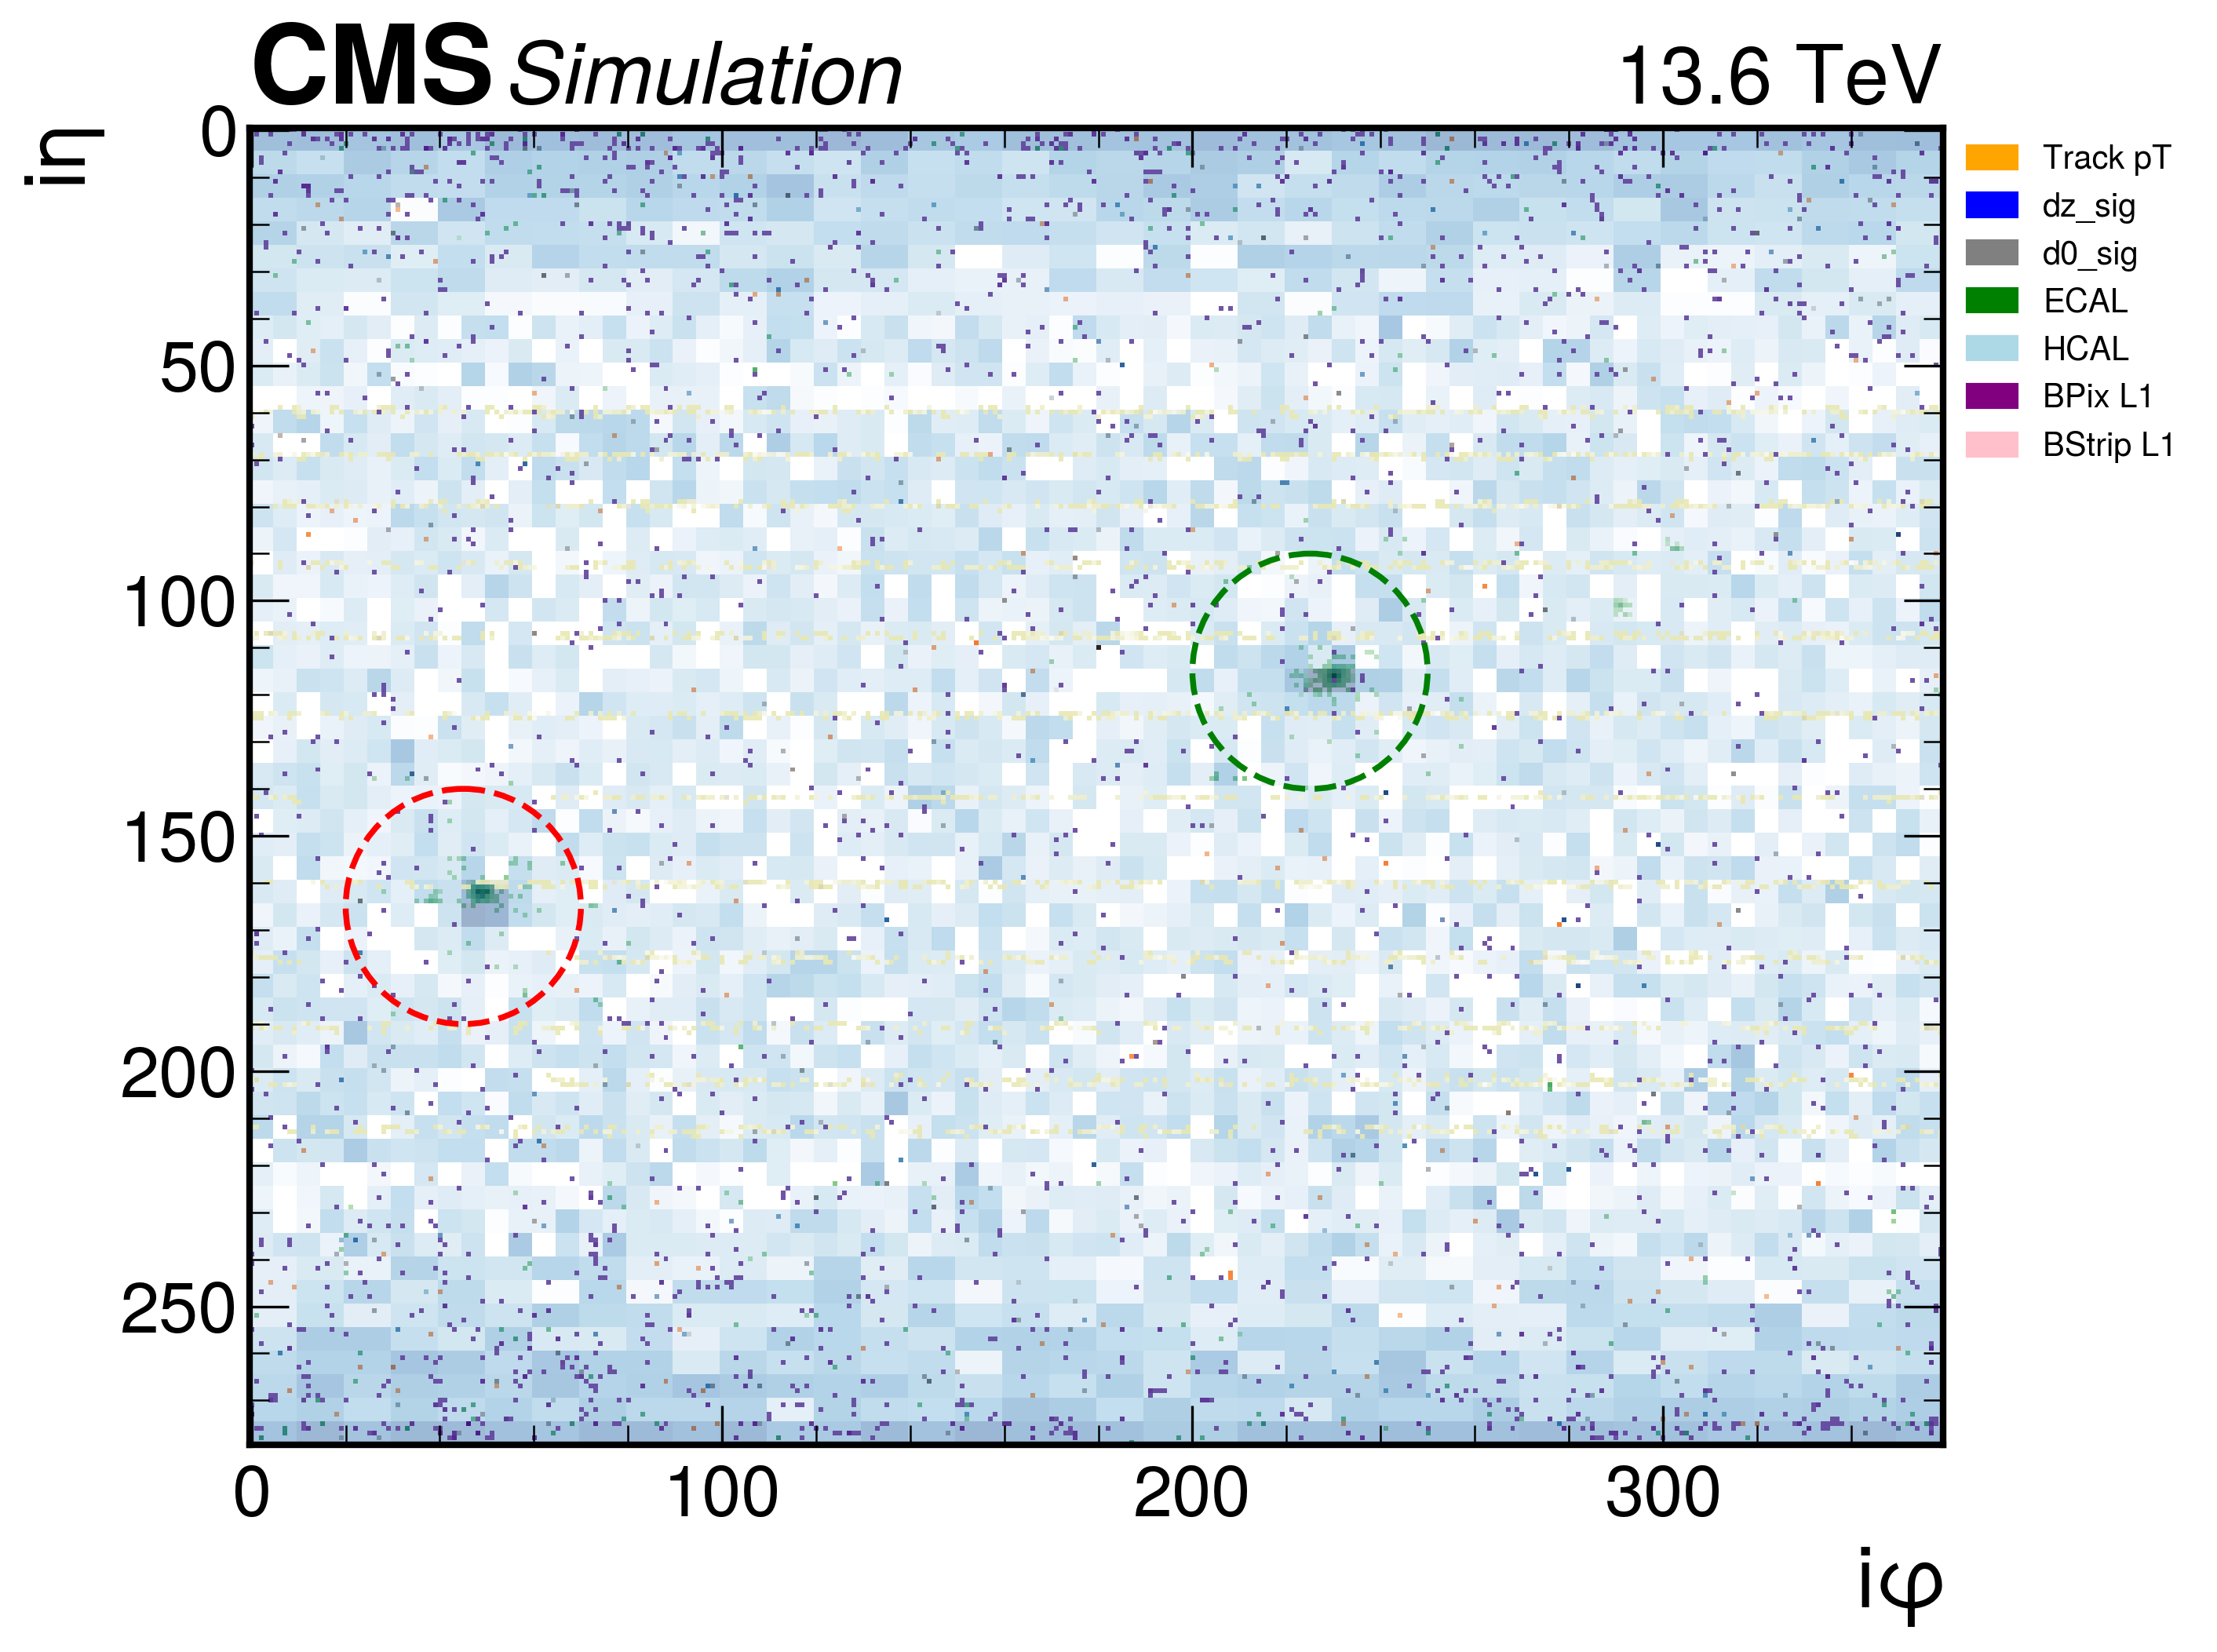

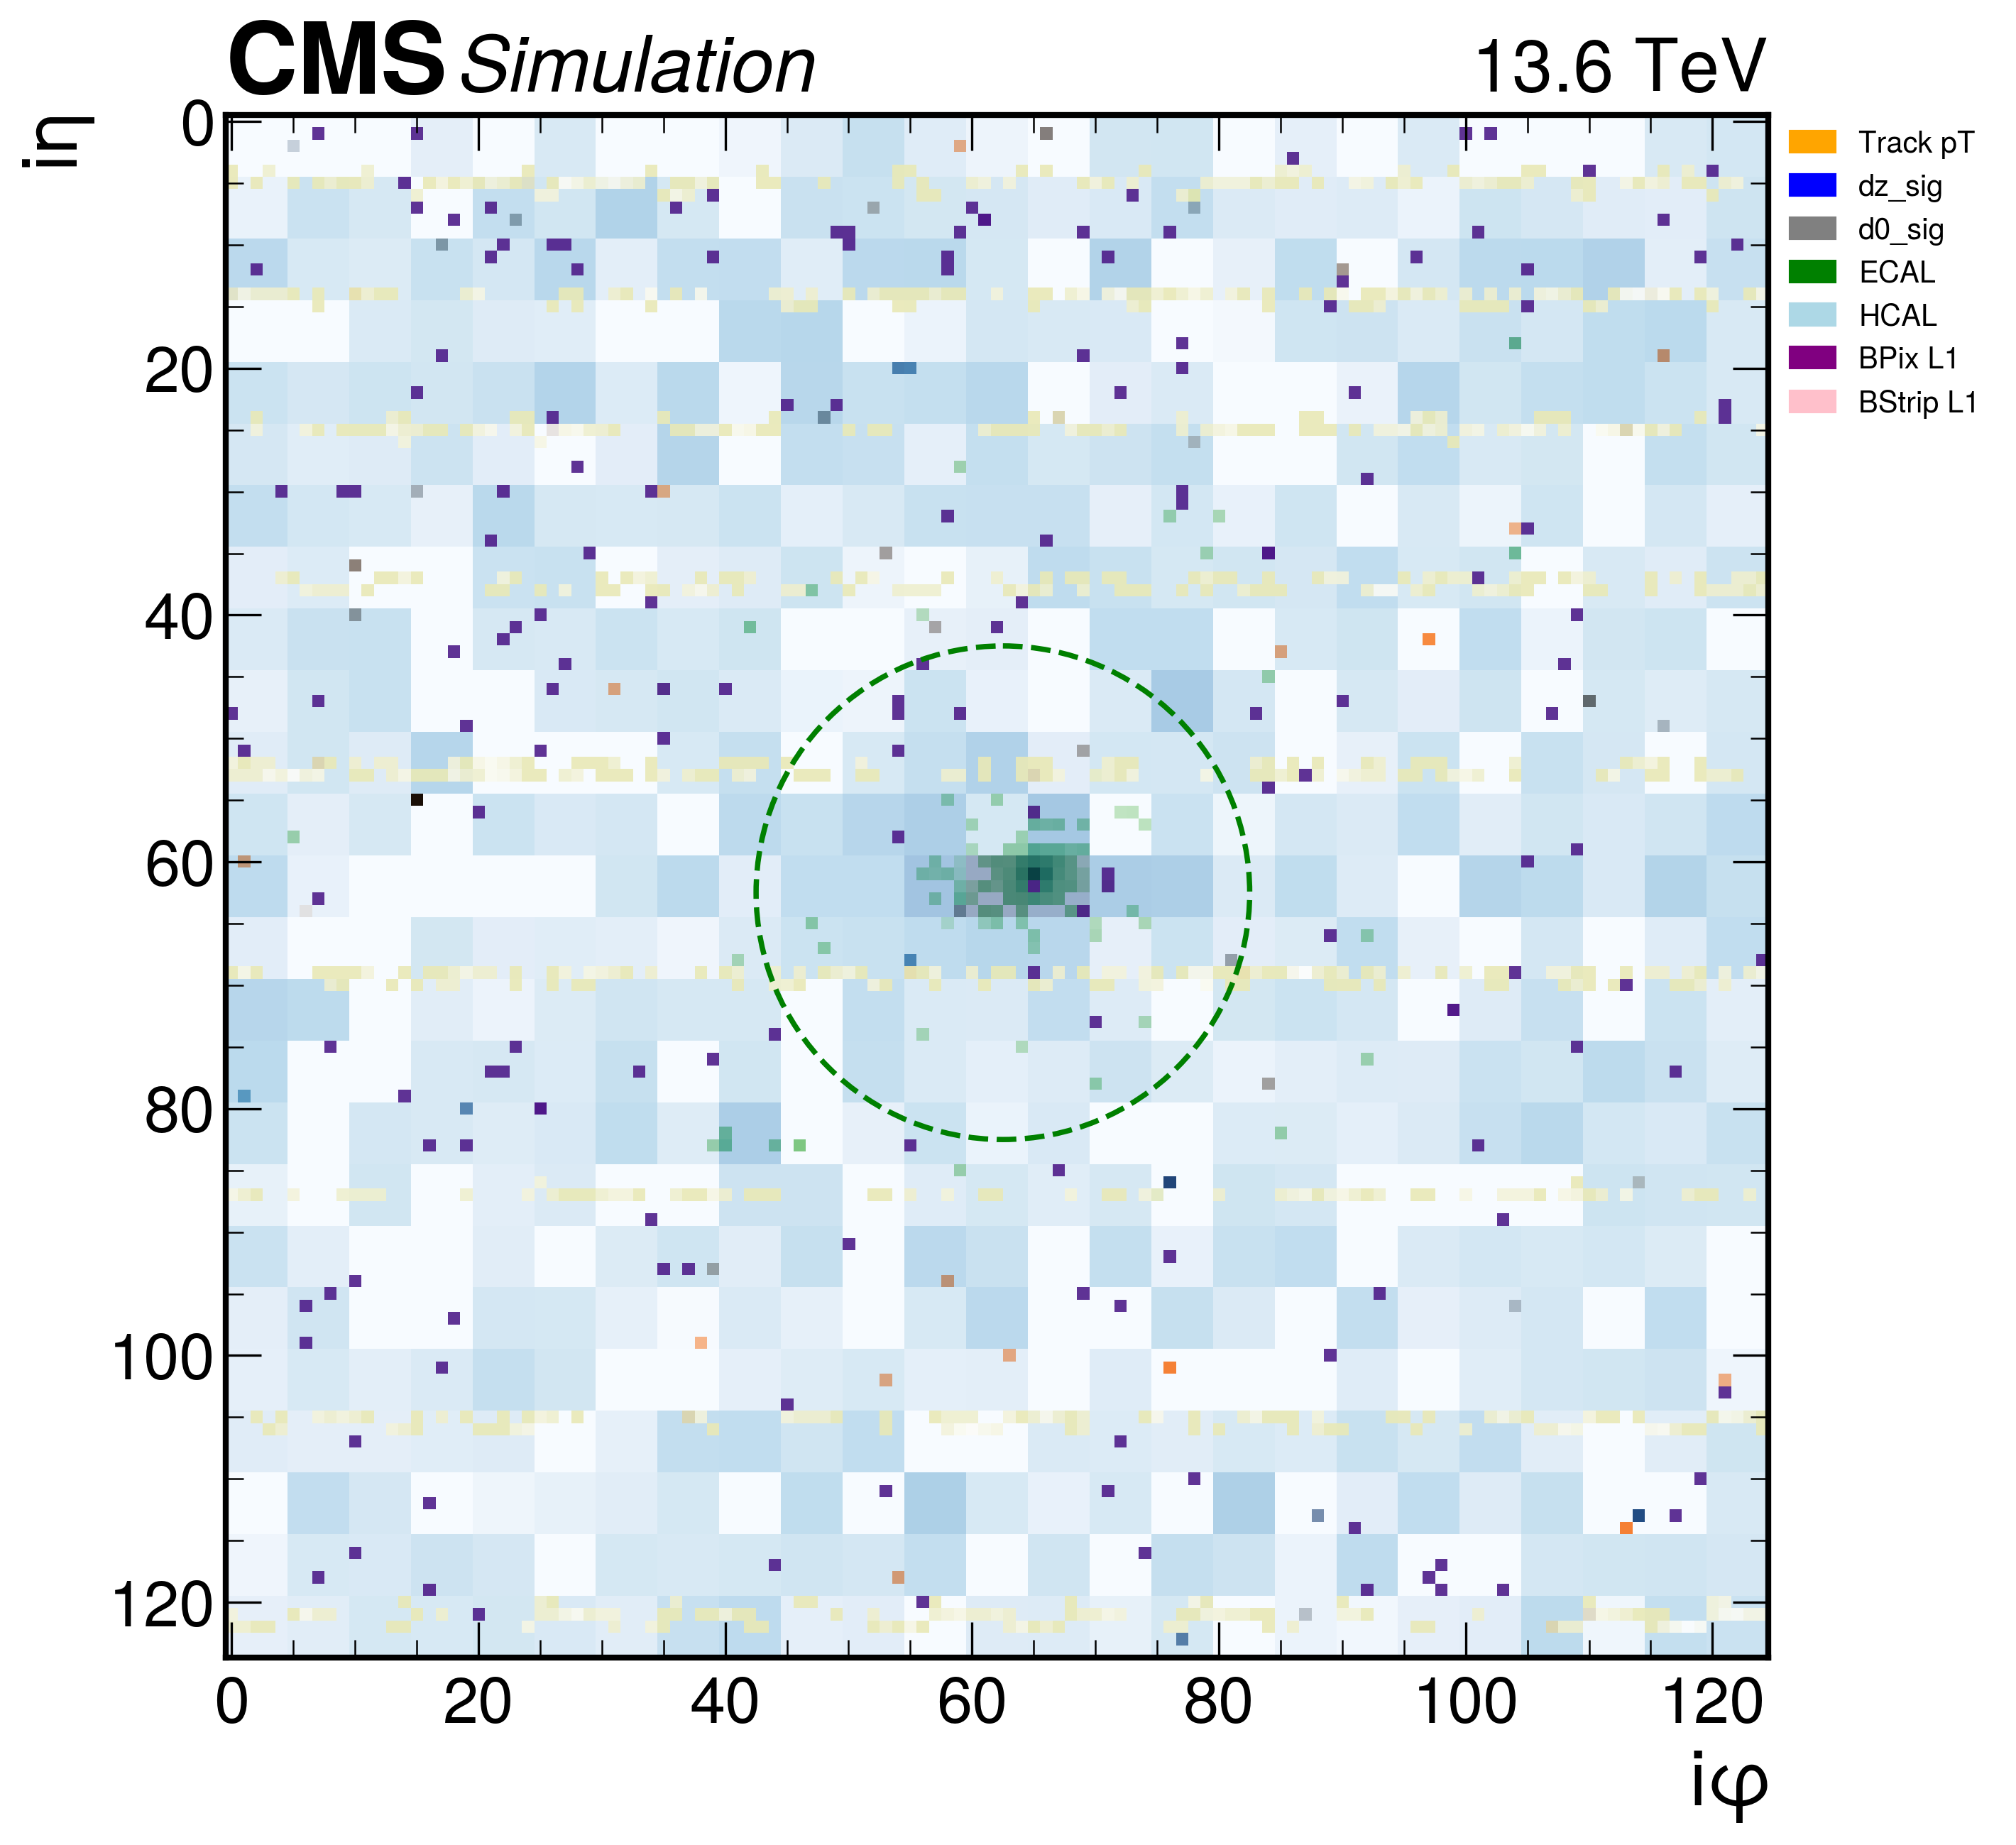

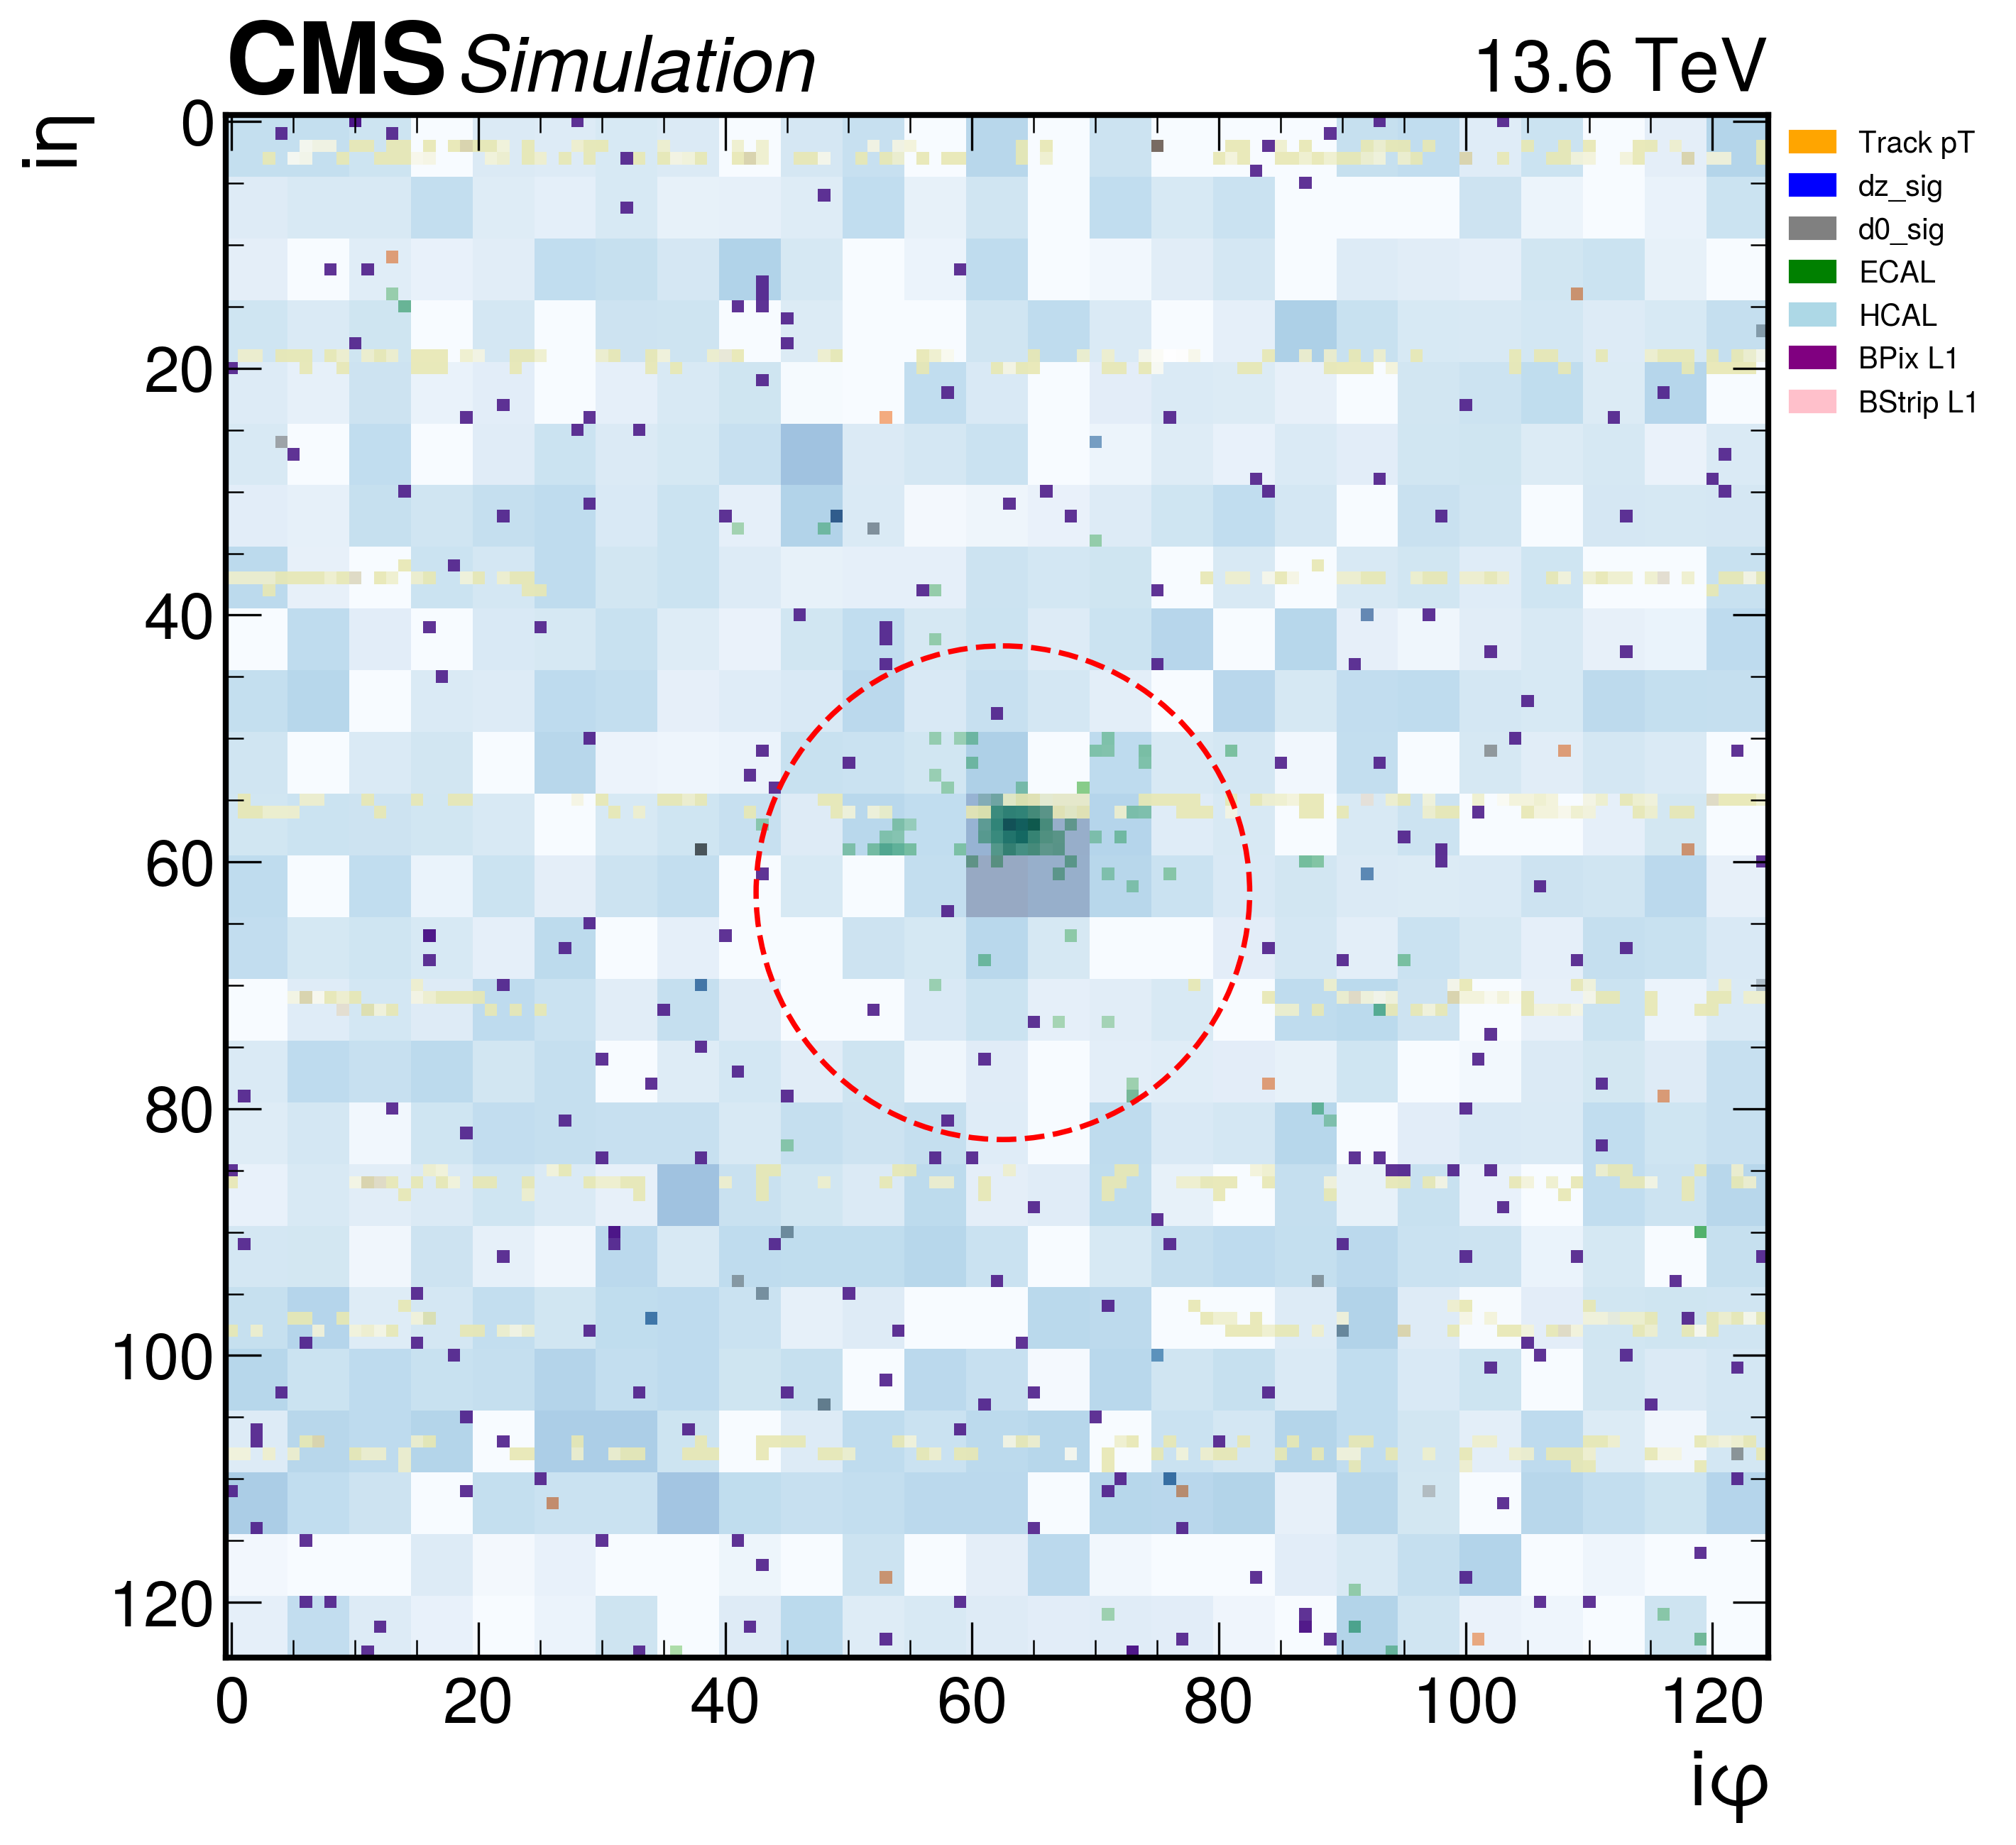

In [65]:
make_img_eve_full_circle_and_cropped_circle(3)

In [9]:
# print(branches.fields)

In [76]:
# for i in [0,4]:
#        make_img_eve_full(i, 3)

In [1]:
# for i in [27,14,61,55,159,102]:
#     make_img_eve_cropped(i)

In [3]:
 # make_img_all_layers_full(1, 3)

In [38]:
# make_img_all_layers_cropped(1, 20)

In [2]:
import numpy as np

def dr(eta, phi):
    deta = 0.175
    dphi = 0.175
    return np.sqrt((eta * deta)**2 + (phi * dphi)**2)


In [10]:
dr(4,4)

0.9899494936611665

In [7]:
1/np.sqrt(2)/.174

4.063832075784756

### Images for signal samples

In [99]:
def plotJet_signal(img, eve, mass):
#     out_dir='plot_for_prelim/Img_A_2Tau_unmerged_dR_1_1p5'
#     if not os.path.isdir(out_dir):
#         os.makedirs(out_dir)
    mins = [0.001]*len(img)
    maxs =[]
    for i in range(len(img)):
        maxs.append(img[i].max())
    fig, ax = plt.subplots(dpi=300)
    if maxs[0]  > 0 : plt.imshow(img[0], cmap='Oranges', norm=LogNorm(vmin=mins[0], vmax=maxs[0]),  alpha=0.9)
    if maxs[1]  > 0 : plt.imshow(img[1], cmap='Blues',   norm=LogNorm(vmin=mins[1], vmax=maxs[1]),  alpha=0.9)
    if maxs[2]  > 0 : plt.imshow(img[2], cmap='Greys',   norm=LogNorm(vmin=mins[2], vmax=maxs[2]),  alpha=0.9)
    if maxs[3]  > 0 : plt.imshow(img[3], cmap='Greens',  norm=LogNorm(vmin=mins[3], vmax=maxs[3]),  alpha=0.9)       
    if maxs[4]  > 0 : plt.imshow(img[4], cmap='Blues',   norm=LogNorm(vmin=mins[4], vmax=maxs[4]),  alpha=0.4)   
    if maxs[5]  > 0 : plt.imshow(img[5], cmap='Purples', norm=LogNorm(vmin=mins[5], vmax=maxs[5]),  alpha=0.9)   
    if maxs[10] > 0 : plt.imshow(img[10], cmap= 'pink',  norm=LogNorm(vmin=mins[10],vmax=maxs[10]), alpha=0.9)
    hep.cms.label(llabel=r"Simulation    ", rlabel=f"     $m_A$={mass} GeV        13.6 TeV", loc=0, ax=ax)
#     plt.title(f"Image event number {eve} ")
    # plt.xlabel(r"$\mathrm{i\varphi}$") #28, 30
    # plt.ylabel(r"$\mathrm{i\eta}$") #28, 30
    plt.xlabel(r"$i\varphi$") #28, 30
    plt.ylabel(r"$i\eta$") #28, 30
    #LEGEND
    colors = {0:'orange',1:'blue',2:'grey',3:'green',4:'lightblue',5:'purple',6:'pink'}
    labels = {0:'Track pT',1:'dz_sig',2:'d0_sig',3:'ECAL',4:'HCAL',5:'BPix L1',6:'BStrip L1'}
    patches =[mpatches.Patch(color=colors[i],label=labels[i]) for i in colors]
    plt.legend(handles=patches, bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.,fontsize=10 )
    plt.tight_layout()
    mass_str = str(mass).replace('.', 'p')
    plt.savefig(f'{out_dir}/image_signal_mass_{mass_str}_event_{eve}.pdf',facecolor='w',dpi=300,)
    plt.show()

    
def plotJet_single_layer_signal(img, mass):
    # img[np.abs(img) < 1.e-3] = 0 # to rmove noise
    mins = [0.00001]*len(img)
    maxs =[]
    for j in range(len(img)):
         maxs.append(img[j].max())
    # out_dir='plot_for_prelim'
    # if not os.path.isdir(out_dir):
    #     os.makedirs(out_dir)
    for k in range(len(img)):
        fig, ax = plt.subplots(dpi=300)
        color = ['Oranges','Blues','Greys','Greens', 'Blues']
        if k<5:
            color_selected = color[k]
        else:
            color_selected = color[2]
            
        if maxs[k]  > 0 : plt.imshow(img[k], cmap=f'{color_selected}', norm=LogNorm(vmin=mins[k], vmax=maxs[k]),  alpha=0.9)
        hep.cms.label(llabel=f"Simulation {layers[k]}   ", rlabel=f"   $m_A$={mass}GeV          13.6 TeV", loc=0, ax=ax)
        plt.xlabel(r"$i\varphi$") #28, 30
        plt.ylabel(r"$i\eta$") #28, 30

        # plt.savefig(f'{out_dir}/full_image_{layers[k]}_signal_mass_{mass}.pdf',facecolor='w',dpi=300)
        plt.show()
    return img 

def make_img_eve_cropped_signal(i, mass):
    ECAL_energy = np.array(branches["ECAL_energy"][i]).reshape(280,360)
    HBHE_energy_ = np.array(branches["HBHE_energy"][i]).reshape(56,72)
    HBHE_energy = upsample_array(HBHE_energy_, 5, 5) # (280, 360)
    TracksAtECAL_pt = np.array(branches["ECAL_tracksPt_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_dZSig = np.array(branches["ECAL_tracksDzSig_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_d0Sig = np.array(branches["ECAL_tracksD0Sig_atECALfixIP"][i]).reshape(280,360)
    PixAtEcal_1        = np.array(branches["BPIX_layer1_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_2        = np.array(branches["BPIX_layer2_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_3        = np.array(branches["BPIX_layer3_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_4        = np.array(branches["BPIX_layer4_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_1        = np.array(branches["TIB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_2        = np.array(branches["TIB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_3        = np.array(branches["TIB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_4        = np.array(branches["TIB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_1        = np.array(branches["TOB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_2        = np.array(branches["TOB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_3        = np.array(branches["TOB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_4        = np.array(branches["TOB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_5        = np.array(branches["TOB_layer5_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_6        = np.array(branches["TOB_layer6_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_1        = np.array(branches["TEC_layer1_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_2        = np.array(branches["TEC_layer2_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_3        = np.array(branches["TEC_layer3_ECAL_atPV"][i]).reshape(280,360)
    TidAtEcal_1        = np.array(branches["TID_layer1_ECAL_atPV"][i]).reshape(280,360)
    X_CMS             = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy, PixAtEcal_1,\
    PixAtEcal_2, PixAtEcal_3, PixAtEcal_4, TibAtEcal_1, TibAtEcal_2, TibAtEcal_3, TibAtEcal_4, TobAtEcal_1,\
                                  TobAtEcal_2, TobAtEcal_3, TobAtEcal_4, TobAtEcal_5, TobAtEcal_6, TidAtEcal_1,\
                                  TecAtEcal_1, TecAtEcal_2, TecAtEcal_3], axis=0) # (23, 280, 360)
    # ys = ak.Array(branches["jetIsSignal"])[i]
    # ys = ak.Array(branches["jetIsDiTau"])[i]
    iphis  = ak.Array(branches["jetSeed_iphi"])[i]
    ietas  = ak.Array(branches["jetSeed_ieta"])[i]
    # dR = ak.Array(branches["TaudR"])[i]
    ys = min(len(iphis), len(ietas))
    print("Event Number:", i, "ys", ys)
    for j in range(0,ys):
            img_cropped = crop_jet(X_CMS, iphis[j], ietas[j], jet_shape=125)
            plotJet_signal(img_cropped, i, mass)
            break
        
def make_img_eve_full_signal(i, mass):
    ECAL_energy = np.array(branches["ECAL_energy"][i]).reshape(280,360)
    HBHE_energy_ = np.array(branches["HBHE_energy"][i]).reshape(56,72)
    HBHE_energy = upsample_array(HBHE_energy_, 5, 5) # (280, 360)
    TracksAtECAL_pt = np.array(branches["ECAL_tracksPt_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_dZSig = np.array(branches["ECAL_tracksDzSig_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_d0Sig = np.array(branches["ECAL_tracksD0Sig_atECALfixIP"][i]).reshape(280,360)
    PixAtEcal_1        = np.array(branches["BPIX_layer1_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_2        = np.array(branches["BPIX_layer2_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_3        = np.array(branches["BPIX_layer3_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_4        = np.array(branches["BPIX_layer4_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_1        = np.array(branches["TIB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_2        = np.array(branches["TIB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_3        = np.array(branches["TIB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_4        = np.array(branches["TIB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_1        = np.array(branches["TOB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_2        = np.array(branches["TOB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_3        = np.array(branches["TOB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_4        = np.array(branches["TOB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_5        = np.array(branches["TOB_layer5_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_6        = np.array(branches["TOB_layer6_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_1        = np.array(branches["TEC_layer1_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_2        = np.array(branches["TEC_layer2_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_3        = np.array(branches["TEC_layer3_ECAL_atPV"][i]).reshape(280,360)
    TidAtEcal_1        = np.array(branches["TID_layer1_ECAL_atPV"][i]).reshape(280,360)
    X_CMS             = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy, PixAtEcal_1,\
    PixAtEcal_2, PixAtEcal_3, PixAtEcal_4, TibAtEcal_1, TibAtEcal_2,  TobAtEcal_1,\
                                  TobAtEcal_2], axis=0) # (23, 280, 360)
    
    plotJet_signal(X_CMS, i, mass)
    
def make_img_all_layers_full(i, mass):
    ECAL_energy = np.array(branches["ECAL_energy"][i]).reshape(280,360)
    HBHE_energy_ = np.array(branches["HBHE_energy"][i]).reshape(56,72)
    HBHE_energy = upsample_array(HBHE_energy_, 5, 5) # (280, 360)
    TracksAtECAL_pt = np.array(branches["ECAL_tracksPt_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_dZSig = np.array(branches["ECAL_tracksDzSig_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_d0Sig = np.array(branches["ECAL_tracksD0Sig_atECALfixIP"][i]).reshape(280,360)
    PixAtEcal_1        = np.array(branches["BPIX_layer1_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_2        = np.array(branches["BPIX_layer2_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_3        = np.array(branches["BPIX_layer3_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_4        = np.array(branches["BPIX_layer4_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_1        = np.array(branches["TIB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_2        = np.array(branches["TIB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_3        = np.array(branches["TIB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_4        = np.array(branches["TIB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_1        = np.array(branches["TOB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_2        = np.array(branches["TOB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_3        = np.array(branches["TOB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_4        = np.array(branches["TOB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_5        = np.array(branches["TOB_layer5_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_6        = np.array(branches["TOB_layer6_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_1        = np.array(branches["TEC_layer1_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_2        = np.array(branches["TEC_layer2_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_3        = np.array(branches["TEC_layer3_ECAL_atPV"][i]).reshape(280,360)
    TidAtEcal_1        = np.array(branches["TID_layer1_ECAL_atPV"][i]).reshape(280,360)
    X_CMS             = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy, PixAtEcal_1,\
    PixAtEcal_2, PixAtEcal_3, PixAtEcal_4, TibAtEcal_1, TibAtEcal_2, TibAtEcal_3, TibAtEcal_4, TobAtEcal_1,\
                                  TobAtEcal_2, TobAtEcal_3, TobAtEcal_4, TobAtEcal_5, TobAtEcal_6, TidAtEcal_1,\
                                  TecAtEcal_1, TecAtEcal_2, TecAtEcal_3], axis=0) # (23, 280, 360)
    iphis  = ak.Array(branches["jetSeed_iphi"])[i]
    ietas  = ak.Array(branches["jetSeed_ieta"])[i]
    print(iphis)
    print(ietas)
    if  len(iphis) >1:
        plotJet_single_layer_signal(X_CMS, mass)   
         

In [105]:
mass = 12
# file = uproot.open(f"../analysis_run3/HToAATo4Tau_M_3p7_pythia8_Run_3.root") # event 4
# file = uproot.open(f"../analysis_run3/HToAATo4Tau_M_14_pythia8_Run_3.root") #5
file = uproot.open(f"../analysis_run3/HToAATo4Tau_M_{mass}_pythia8_2018UL.root") # 3,3,2

RHTree = file["fevt/RHTree"]
branches = RHTree.arrays(entry_start=0, entry_stop=10)
# out_dir='data/plot_H_AA_4Tau_M_10_signal_kinematics'
out_dir='../analysis_run3/AN_Note_Plot'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

Event Number: 2 ys 2


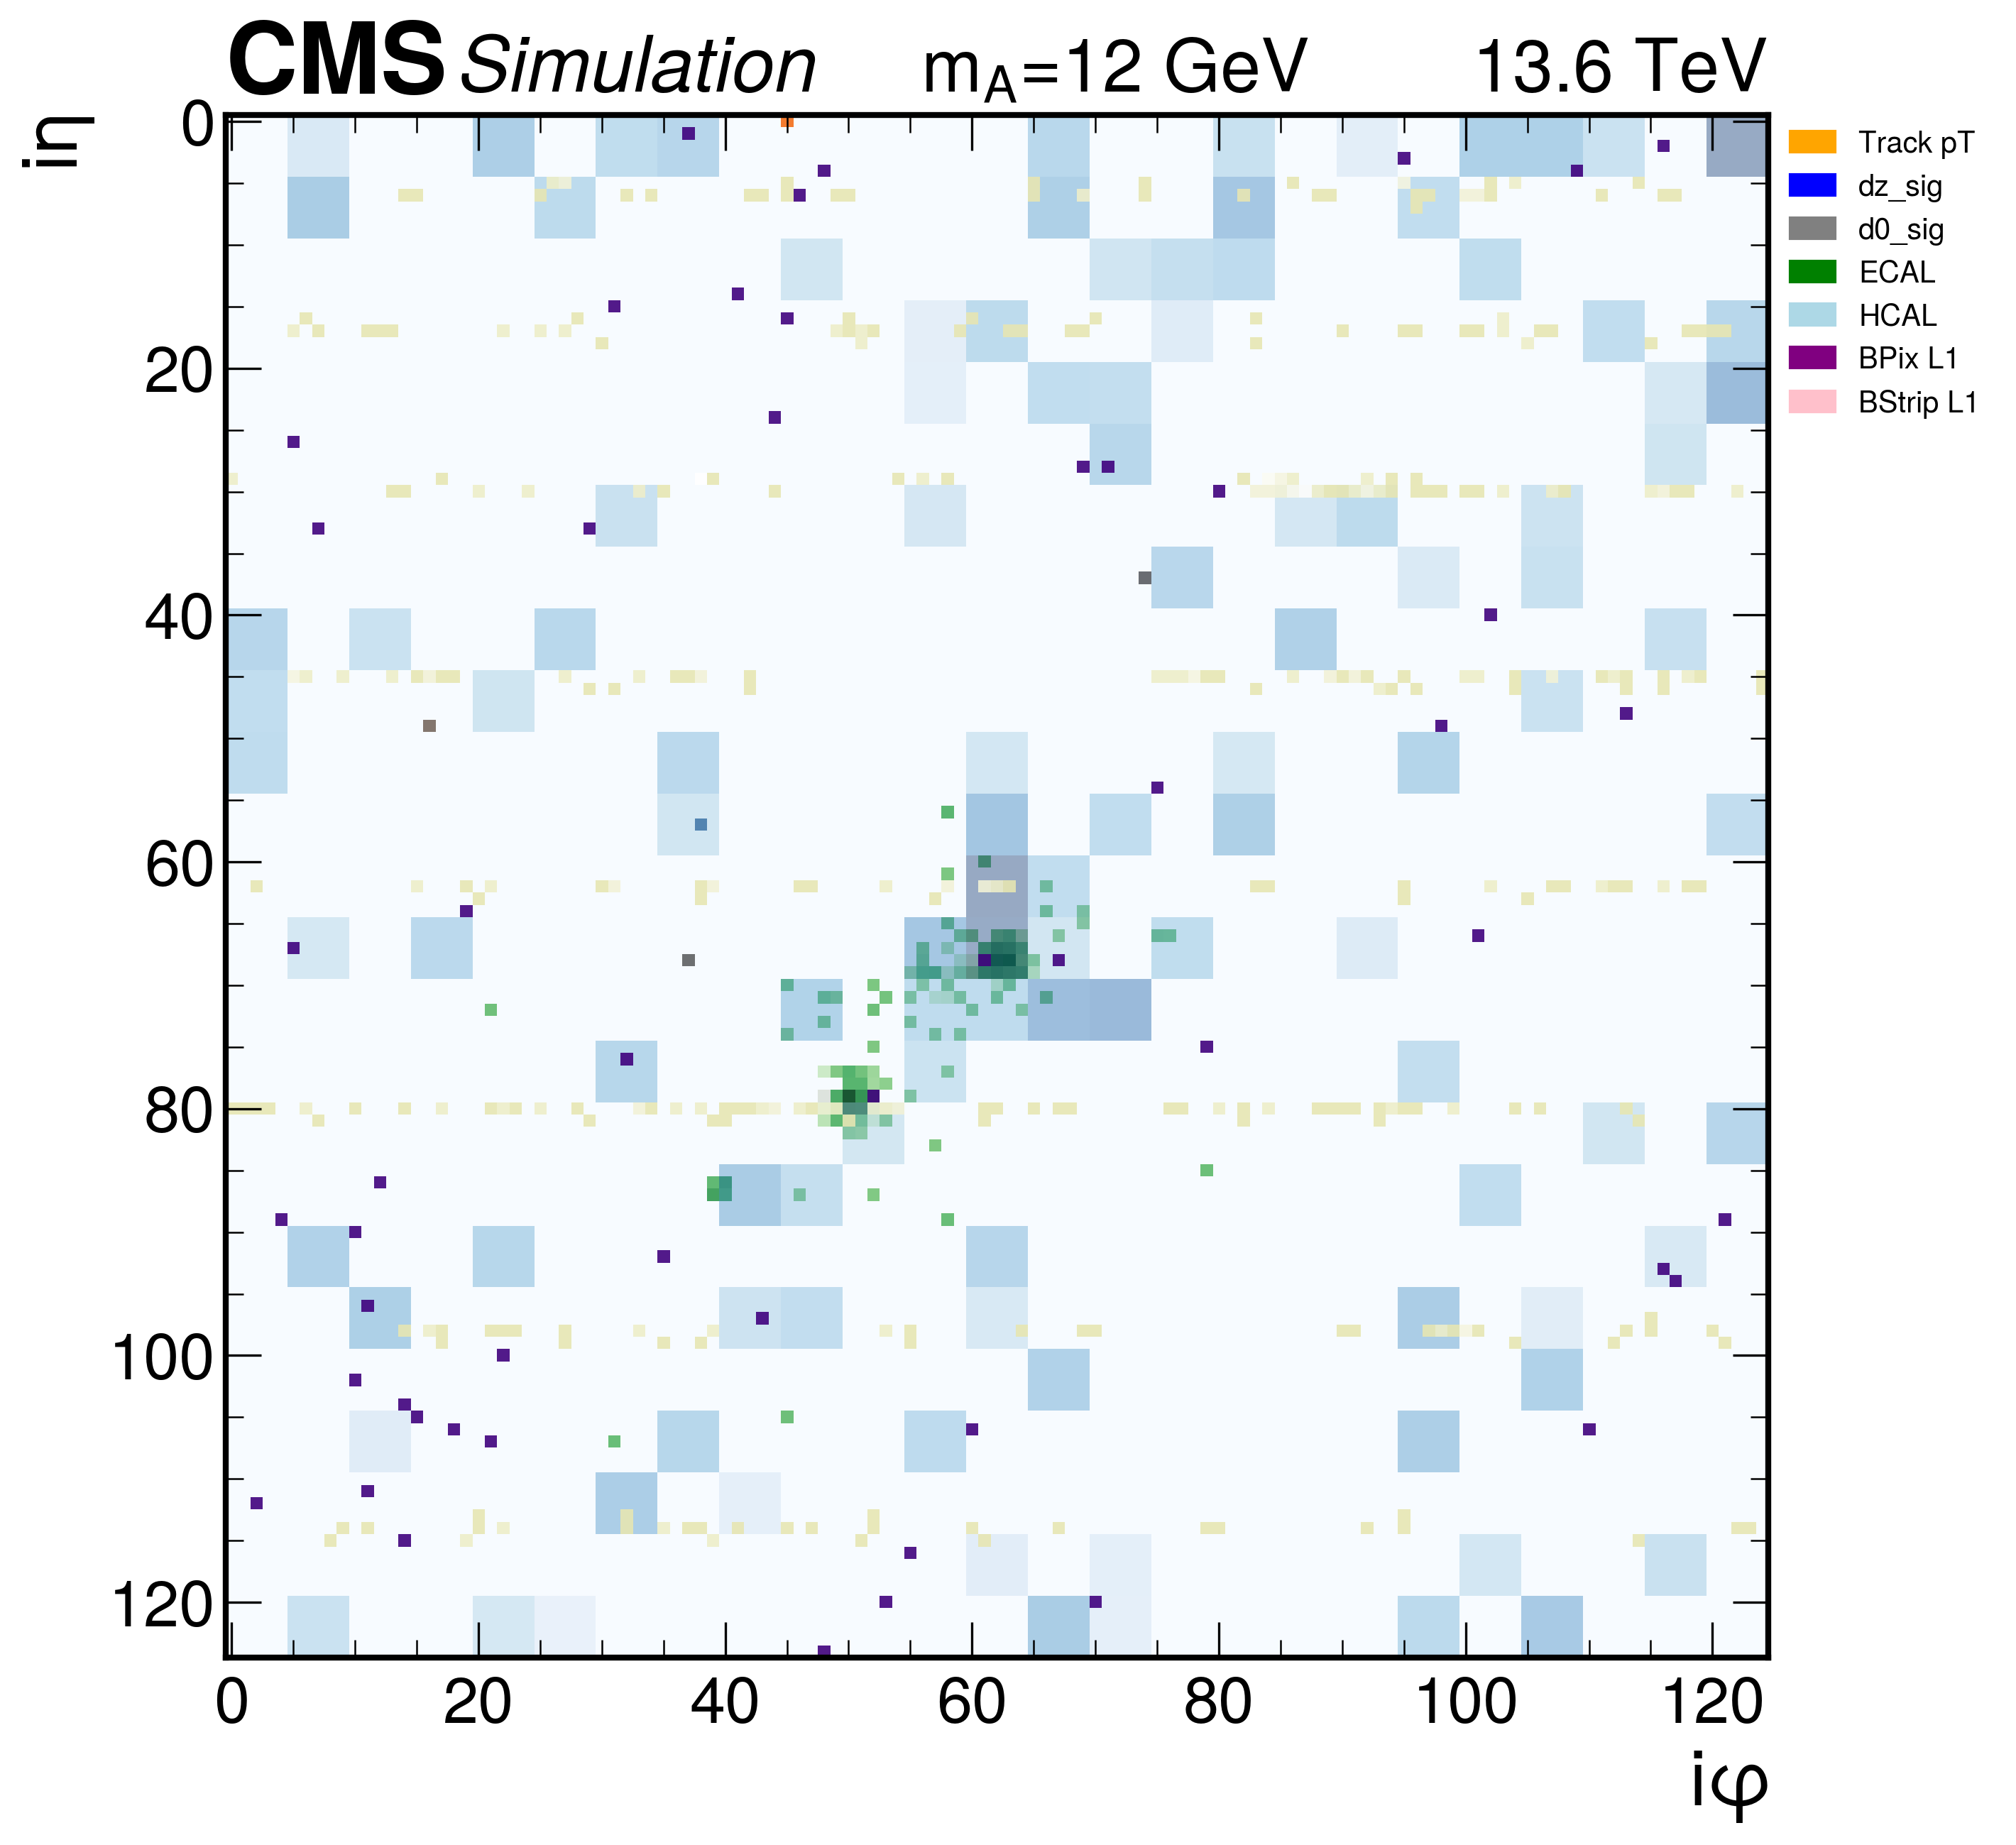

In [106]:
for i in [2]:
    make_img_eve_cropped_signal(i, mass)

In [51]:
# for i in range(0,2):
#     make_img_eve_full_signal(i, mass)

In [46]:
# make_img_all_layers_full(0, mass)

In [59]:
ys = ak.Array(branches["jetIsSignal"])[0]